In [1]:
import pandas as pd
import json
import Tool
import os
import numpy  as np
import operators_v4
import tqdm
from joblib import Parallel, delayed
import sys
sys.path.append("C:/Users/User/我的雲端硬碟 (owen.lin@mutual-boost.com)/MBQ_Tej_v2/MBQ_tej_v2")
import MBQ_tej_v2_manager
args = json.load(open("./config.json", encoding="utf-8"))
save_path = r'C:\Users\User\Desktop\pc\stcok\Results\Results.xlsx'

In [2]:
Handler_cache_path = args['Handler_cache_path']
print(f"Load Data : {Handler_cache_path}")
CacheHandler = Tool.Handler(path = Handler_cache_path,data_type = args['data_type'])

Load Data : C:\Users\User\Documents\MBQ_TW_DB


In [3]:
df_result = pd.read_excel(save_path,index_col=0)
import fitness
df_result['use_data'] = df_result['cal'].apply(lambda X:fitness.parse_expression(X,False)[1])
df_result['len'] = df_result['cal'].apply(lambda X:fitness.parse_expression(X,True))
原始大小 = len(df_result)

use_data_df = pd.DataFrame([(k, v) for k, values in df_result.set_index('cal')['use_data'].items() for v in values], columns=['key', 'value'])
use_factor = use_data_df.groupby('value')['key'].apply(list)
use_factor_count = use_factor.str.len().sort_values(ascending=False)
df_result_list = []
top_n = 100
for factor_name in tqdm.tqdm(use_factor_count.index[:]):
    df_result_ = df_result.loc[df_result['cal'].str.contains(factor_name)].sort_values('fitness',ascending=False)
    Top = df_result_.index[:top_n]
    Down = df_result_.index[top_n:]
    if len(Down):
        df_result = df_result.drop(index = Down)
    df_result_list.append(df_result.loc[Top])
best_df_result = pd.concat(df_result_list).drop_duplicates('cal').sort_values('fitness',ascending=False).iloc[:1000]
print(f'因子数{len(best_df_result)}/{原始大小}')
print(f'{best_df_result.fitness.mean()}')

100%|██████████| 14/14 [00:00<00:00, 927.62it/s]

因子数15/15
330.6774053169944


In [4]:
target = eval(args['TARGET_Expr'],CacheHandler)
exp_ret = target = target[np.isfinite(target)]

In [5]:
expr_list = df_result.sort_values('fitness',ascending=False)['cal'].to_list()
index = exp_ret.stack().index
def get_factor_stack(expr,index,args):
    CacheHandler = Tool.Handler(path = args['Handler_cache_path'],data_type = args['data_type'])
    return eval(expr,CacheHandler).stack(dropna = False).reindex(index = index)
factor_df = pd.DataFrame(np.column_stack(Parallel(n_jobs=-1)(delayed(get_factor_stack)(expr,index,args) for expr in tqdm.tqdm(expr_list))),index=index,columns=expr_list)

100%|██████████| 15/15 [00:00<00:00, 990.17it/s]


In [6]:
def calc_IC_series(factor: pd.DataFrame, exp_ret: pd.DataFrame) -> pd.Series:
    IC_series = factor.corrwith(exp_ret, axis=1, method='spearman')
    return IC_series.sort_index()

def run_IC_test(IC_series: pd.Series, insample_start_date: str, insample_end_date: str) -> pd.DataFrame:
    insample_start = pd.to_datetime(insample_start_date)
    insample_end = pd.to_datetime(insample_end_date)
    outsample_start = pd.to_datetime("2020-01-01")

    IC_mean = pd.Series({
        f"樣本內({insample_start.date()}~{insample_end.date()})": IC_series.loc[insample_start:insample_end].mean(),
        f"樣本外({outsample_start.date()}~{IC_series.index[-1].date()})": IC_series.loc[outsample_start:].mean(),
    })

    ICIR = pd.Series({
        f"樣本內({insample_start.date()}~{insample_end.date()})": IC_mean[0] / IC_series.loc[insample_start:insample_end].std(),
        f"樣本外({outsample_start.date()}~{IC_series.index[-1].date()})": IC_mean[1] / IC_series.loc[outsample_start:].std(),
    })

    return pd.concat({"IC": IC_mean, "ICIR": ICIR}, axis=1)

In [7]:
# 因子檢定模式 = True
# if 因子檢定模式:
#     IC_Se = calc_IC_series(factor_df
#                            ['非负化处理(abs(truediv(signedpower(非负化处理(cs_scale(abs(truediv(signedpower(非负化处理(cs_scale(daily_EMA20, 10)), 30), Volume)), 30)), 3), FAC)))'].unstack(), exp_ret)
#     display(run_IC_test(IC_Se, insample_start_date='2015-01-01', insample_end_date='2019-12-31'))
#     Tool.backtest_factor(factor_df
#                            ['非负化处理(abs(truediv(signedpower(非负化处理(cs_scale(abs(truediv(signedpower(非负化处理(cs_scale(daily_EMA20, 10)), 30), Volume)), 30)), 3), FAC)))'].unstack(), exp_ret, rank_range_n=10, start_date='2019-12-31')
#     IC_Se.ewm(span=60).mean().dropna().iloc[60:].iplot(hline=[IC_Se.mean()])

In [8]:
factor_df.to_pickle('factor_df.pkl')

# 因子整体等权监控

In [9]:
import os
from datetime import time
from datetime import datetime
import numpy as np
import pandas as pd
import json
import pathlib
import tqdm
import Tool
import fitness
def 剔除高度相关(df_result,ts_result,Corr_threshold:float = 0.95):
    要删除的清单 = list()
    #根據因子本身序列評價單因子績效並排序
    #cv_df = ts_result.mean() / ts_result.std()
    #ts_result = ts_result[cv_df.sort_values(ascending = False).index]

    Corr_df = ts_result.corr().abs()
    for factor_expr in ts_result.columns:
        if factor_expr not in 要删除的清单:
            Corr_ = Corr_df.loc[factor_expr:,factor_expr].iloc[1:]
            要删除的清单+=Corr_[Corr_>Corr_threshold].index.to_list()
    要删除的清单 = list(set(要删除的清单))
    if 要删除的清单:
        print(f'发现:{len(要删除的清单)}个表达式与其他其他表达式相关超过{Corr_threshold}，执行删除！！！')
    else:
        print(f'没有相关超过{Corr_threshold}的表达式！！！')
    df_result = df_result.loc[~df_result['cal'].isin(要删除的清单)]
    ts_result = ts_result[df_result['cal'].to_list()]
    return df_result,ts_result

start_time = datetime.now()
print(f"Init variables:{start_time}.")
args = json.load(open("./config.json", encoding="utf-8"))
if args['OUTPUT_DATA_PATH'][:2] == './':
    args['OUTPUT_DATA_PATH'] = str(pathlib.Path().absolute())+args['OUTPUT_DATA_PATH'][1:]
# Data preprocessing
Handler_cache_path = args['Handler_cache_path']
print(f"Load Data : {Handler_cache_path}")
CacheHandler = Tool.Handler(path = Handler_cache_path,data_type = args['data_type'])

Con = eval(args['Con'],CacheHandler)
target = eval(args['TARGET_Expr'],CacheHandler)
target = target[np.isfinite(target) & Con]
print(f"Target : ({args['TARGET_Expr']})[{args['Con']}]")

使用太多次需剔除的data_name = []
if os.path.exists(args['OUTPUT_DATA_PATH']):
    ts_result_path = os.path.join(os.path.dirname(args['OUTPUT_DATA_PATH']),f"{args['OUTPUT_DATA_PATH'].split('/')[-1].replace('.xlsx','')}.parquet")
    ts_result = pd.read_parquet(ts_result_path)
    df_result = pd.read_excel(args['OUTPUT_DATA_PATH'],index_col=0)
    df_result,ts_result = 剔除高度相关(df_result,ts_result,args['Corr_threshold'])
    # 开始确认源资料使用频繁程度
    df_result['use_data'] = df_result['cal'].apply(lambda X:fitness.parse_expression(X,False)[1])
    df_result = df_result.loc[df_result['fitness']>args['FIT_THRES']]
    print(f"{args['OUTPUT_DATA_PATH']} 已存在，载入历史{len(df_result)}个历史因子")
    use_data_df = pd.DataFrame([(k, v) for k, values in df_result.set_index('cal')['use_data'].items() for v in values], columns=['key', 'value'])
    use_factor = use_data_df.groupby('value')['key'].apply(list)
    use_factor_count = use_factor.str.len().sort_values(ascending=False)
    使用太多次需剔除的data_name = use_factor_count.loc[use_factor_count>=args['use_data_count_threshold']].index.to_list()
    if 使用太多次需剔除的data_name:
        print(f'剔除:{使用太多次需剔除的data_name}')
    print(f'Mega Factor Score Up to:{ts_result.mean(axis = 1).mean() / ts_result.mean(axis = 1).std() * 252**0.5}')
else:
    df_result = pd.DataFrame(columns=['cal', 'fitness', 'use_data'])
    ts_result = pd.DataFrame()
count = 0
if args['AMT']=="None" or args['AMT']=="inf": args['AMT'] = np.inf


def factor_to_weight(alpha_array,only_long:bool = False):
    demeaned = alpha_array - np.nanmean(alpha_array,axis = 1)[:, None]
    weights = demeaned / np.nansum(np.abs(demeaned),axis = 1)[:, None]
    weights[np.isnan(weights)] = 0#检查数据无值时视为权重0
    if only_long:
        weights[weights<0] = 0
        weights*=2
    return weights

Full_time_ts_result = pd.concat({expr:factor_to_weight(eval(expr,CacheHandler)[target.notna()],True).mul(CacheHandler['Adj_close'].shift(-2) / CacheHandler['Adj_close'].shift(-1) -1).sum(axis = 1) for expr in tqdm.tqdm(df_result['cal'][:])},axis=1)

Init variables:2025-04-08 13:06:31.527886.
Load Data : C:\Users\User\Documents\MBQ_TW_DB
Target : (Adj_close.shift(-21) / Adj_close.shift(-1) - 1)[(Value_Dollars.rolling(5).mean() > 0)]
没有相关超过0.8的表达式！！！
c:\Users\User\Desktop\pc\stcok/Results/Results.xlsx 已存在，载入历史15个历史因子
Mega Factor Score Up to:11.239586854105067


100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


In [10]:
# top15_expr_list = df_result['cal'].head(15).tolist()
# print("前15個因子如下：")
# print(top15_expr_list)

# # 對前 15 個因子進行回測計算
# Full_time_ts_result = pd.concat({
#     expr: factor_to_weight(eval(expr, CacheHandler)[target.notna()], only_long=True)
#     .mul(CacheHandler['Adj_close'].shift(-2) / CacheHandler['Adj_close'].shift(-1) - 1)
#     .sum(axis=1)
#     for expr in tqdm.tqdm(top15_expr_list)
# }, axis=1)

In [11]:
bt_ret = Full_time_ts_result.mean(axis=1)
Tool.show_stats(pd.concat({
    '樣本內':bt_ret.loc[args['DATE_FROM']:args['DATE_TO']],
    '樣本外':bt_ret.loc[args['DATE_TO']:],
    '全樣本':bt_ret.loc[:],
},axis = 1))
bt_ret.cumsum().iplot(vline = [args['DATE_FROM'],args['DATE_TO']])

,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),样本胜率(%),周胜率(%),月胜率(%),年胜率(%),盈亏比(avg_win/avg_loss),总赚赔比(profit_factor),预期报酬(bps),样本数
樣本內,110.60,8.24,8.52,-12.99,-2.63,70.36,81.88,99.07,100.0,1.67,3.99,44.11,2223
樣本外,35.93,5.50,2.51,-14.34,-6.35,63.23,73.09,88.16,100.0,1.46,2.65,18.16,1515
全樣本,186.28,7.15,12.99,-14.34,-2.63,67.47,78.27,94.57,100.0,1.60,3.41,62.35,3738


In [12]:

combined_list = [
    'PBR_TWSE','Total_Operating_Income','Earnings_Before_Interest_and_Tax','Total_Liabilities','Cash_and_Cash_Equivalent','Total_Operating_Income','Basic_Earnings_Per_Share','Return_Rate_on_Equity_A_percent',
    'Total_Assets','Sales_Monthly','Cash_Flow_from_Operating_Activities','Cash_Dividend_Yield_TEJ','Return_on_Total_Assets_A_percent','Net_Operating_Income_Loss'
]


In [13]:
# first = pd.read_parquet('./Results/v4.parquet')
# second = pd.read_parquet('./Results/Results.parquet')
# final = pd.concat([first,second],axis = 1)
# final.to_parquet('./Results/Results.parquet')

In [14]:
manage = MBQ_tej_v2_manager.Handler()

In [15]:
# def manage_factors(CacheHandler):
#     for factor_name in combined_list:
#         if factor_name in CacheHandler.cash_list():
#             continue

#         # 讀入資料並 pivot
#         factor_data = manage(factor_name)
#         if 'mdate' in factor_data.index.names and len(factor_data.columns) > 1:
#             all_factor = factor_data
#         else:
#             Q_columns = [col for col in factor_data.columns if col.endswith('_Q')]
#             required_columns = ['mdate', 'coid'] + Q_columns
#             factor_data_Q = factor_data[required_columns]
#             all_factor = factor_data_Q.pivot(index='mdate', columns='coid', values=Q_columns)
#             if isinstance(all_factor.columns, pd.MultiIndex):
#                 all_factor.columns = all_factor.columns.droplevel(0)

#         all_factor_filtered = all_factor
#         CacheHandler[factor_name] = all_factor_filtered

#     return CacheHandler
# manage_factors(CacheHandler)

In [16]:
def manage_factors(CacheHandler):
    factor_dict = {}

    def add_factor(factor_name, formula):
        factor_dict[factor_name] = formula
        CacheHandler[factor_name] = formula

    add_factor('52_high', CacheHandler['Adj_Close'] / CacheHandler['Adj_Close'].rolling(252).max())
    add_factor('EP', CacheHandler['Basic_Earnings_Per_Share'] / CacheHandler['Adj_Close'])
    EV = CacheHandler['Value_Dollars'] + CacheHandler['Total_Liabilities'] - CacheHandler['Cash_and_Cash_Equivalent']
    add_factor('EBIT_to_EV', CacheHandler['Earnings_Before_Interest_and_Tax'] / EV)
    bp_quantile = CacheHandler['PBR_TWSE'].rank(pct=True).apply(lambda x: 1 / x)
    roe_quantile = CacheHandler['Return_Rate_on_Equity_A_percent'].rank(pct=True).apply(lambda x: 1 / x)
    add_factor('BPROE_Quantile', bp_quantile + roe_quantile)
    add_factor('Log PS', CacheHandler['Total_Operating_Income'] / CacheHandler['Value_Dollars'].apply(np.log))
    add_factor('One-month change', (CacheHandler['Adj_Close'] - CacheHandler['Adj_Close'].shift(20)) / CacheHandler['Adj_Close'].shift(20))
    add_factor('MoM5', CacheHandler['Adj_Close'] / CacheHandler['Adj_Close'].shift(5) - 1)
    add_factor('MoM20', CacheHandler['Adj_Close'] / CacheHandler['Adj_Close'].shift(20) - 1)
    add_factor('MoM60', CacheHandler['Adj_Close'] / CacheHandler['Adj_Close'].shift(60) - 1)
    add_factor('MoM252', CacheHandler['Adj_Close'] / CacheHandler['Adj_Close'].shift(252) - 1)
    add_factor('Turn20', CacheHandler['Turnover'].rolling(20).mean())
    add_factor('PctTurn', CacheHandler['Turnover'] / CacheHandler['Turnover'].rolling(40).mean().shift(20) - 1)
    add_factor('PctTurn20', (CacheHandler['Turnover'] / CacheHandler['Turnover'].rolling(40).mean().shift(20) - 1).rolling(20).mean())
    add_factor('振幅', (CacheHandler['Adj_High'] - CacheHandler['Adj_Low']) / CacheHandler['Adj_Close'].shift(1))
    add_factor('振幅換手率因子', ((CacheHandler['Turnover'] / CacheHandler['Turnover'].rolling(40).mean().shift(20) - 1) * ((CacheHandler['Adj_High'] - CacheHandler['Adj_Low']) / CacheHandler['Adj_Close'].shift(1))).rolling(20).mean())
    add_factor('STR', CacheHandler['Turnover'].rolling(20).std())
    add_factor('Vol20', (CacheHandler['Adj_Close'] / CacheHandler['Adj_Close'].shift() - 1).rolling(20).std())
    add_factor('SCR', CacheHandler['Turnover'].rolling(20).std() / CacheHandler['Turnover'].rolling(40, min_periods=1).std().shift(20) - 1)
    add_factor('DRET', (CacheHandler['Adj_Close'] - CacheHandler['Adj_Open']) / CacheHandler['Adj_Close'].shift(1))
    add_factor('FAC', (CacheHandler['Adj_High'] - CacheHandler['Adj_Low']) / CacheHandler['Adj_Close'].shift(1))
    add_factor('PLUS', (2 * CacheHandler['Adj_Close'] - CacheHandler['Adj_High'] - CacheHandler['Adj_Low']) / CacheHandler['Adj_Close'].shift(1))
    add_factor('daily_turnover_change', CacheHandler['Turnover'] / CacheHandler['Turnover'].shift(1) - 1)
    add_factor('daily_turnover_change_ma20', (CacheHandler['Turnover'] / CacheHandler['Turnover'].shift(1) - 1).rolling(20).mean())
    add_factor('gtr', (CacheHandler['Turnover'] / CacheHandler['Turnover'].shift(1) - 1).rolling(20).std())
    intraday_ret = (CacheHandler['Adj_Close'] - CacheHandler['Adj_Open']) / CacheHandler['Adj_Open']
    add_factor('intraday_return_ewm_vol20', intraday_ret.pct_change().ewm(span=20).mean())

    return factor_dict

factor_dict = manage_factors(CacheHandler)


In [17]:
factor_cols = [col for col in factor_df.columns if col not in ['mdate', 'coid']]
factor_df.reset_index(inplace=True)
factor_dict_gene = {
    factor: factor_df.pivot(index='mdate', columns='coid', values=factor)
    for factor in factor_cols
}

In [18]:
final_factor_dict = {**factor_dict, **factor_dict_gene}

In [19]:
import bottleneck as bn

In [20]:
class FactorCombination:
    def __init__(self, stock_return=None):
        """
        Initialize the FactorCombination class.

        Parameters:
        - stock_return: DataFrame, optional
            Stock return data, typically in decimal format.
        """
        self.stock_return = stock_return

    @staticmethod
    def get_stock_return_close_to_close(daily_return_data):
        """
        Calculate close-to-close stock return from daily percentage return data.

        Parameters:
        - daily_return_data: DataFrame
            Daily percentage return data.

        Returns:
        - DataFrame: Stock returns as decimal values.
        """
        return daily_return_data.div(100)

    @staticmethod
    def get_demean_weighting(data):
        """
        Calculate demeaned and normalized weighting.

        Parameters:
        - data: DataFrame
            Input factor data.

        Returns:
        - DataFrame: Demeaned and normalized weighting.
        """
        df = data.dropna(axis=0, how='all').dropna(axis=1, how='all').copy()
        demean = df.sub(df.mean(axis=1, skipna=True), axis=0)
        weighting = demean.div(demean.abs().sum(axis=1, min_count=1, skipna=True), axis=0)
        weighting = weighting.replace([np.inf, -np.inf], np.nan)
        return weighting

    def combine_factor(self, factor_dict, method='equal_weight', period=250, std_power=1, half_life=126):
        """
        Combine multiple factors using the specified method.

        Parameters:
        - factor_dict: dict
            Dictionary of factors to combine.
        - method: str
            Combination method ('equal_weight', 'double_momentum', 'IC_IR_model', or 'PCA').
        - period: int
            Rolling period for momentum calculation (used in 'double_momentum').
        - std_power: int
            Exponent for standard deviation in momentum weighting (used in 'double_momentum').

        Returns:
        - DataFrame: Combined factor.
        """
        if not factor_dict:
            raise ValueError("factor_dict is empty. Ensure that factors are properly calculated before combining.")

        if method == 'equal_weight':
            multi_factor_weighting = self.get_demean_weighting(list(factor_dict.values())[0]).fillna(0)
            for factor in list(factor_dict.values())[1:]:
                demean_factor = self.get_demean_weighting(factor).fillna(0)
                multi_factor_weighting = multi_factor_weighting.add(demean_factor, fill_value=0)
            factor_all = multi_factor_weighting

        elif method == 'double_momentum':
            if self.stock_return is None:
                raise ValueError("stock_return is required for 'double_momentum' method.")
            factor_all = self.double_momentum_model(factor_dict=factor_dict, period=period, std_power=std_power)
        elif method == 'IC_IR_model':
            if self.stock_return is None:
                raise ValueError("stock_return is required for 'IC_IR' method.")
            factor_all = self.IC_IR_model(factor_dict=factor_dict, stock_return=self.stock_return, period=period)
        elif method == 'PCA':
            factor_all = self.pca_model(factor_dict=factor_dict)
        elif method == 'half_ic_ir_model':
            if self.stock_return is None:
                raise ValueError("stock_return is required for 'half_ic_ir_model' method.")
            factor_all = self.half_ic_ir_model(factor_dict=factor_dict, period=period, half_life=half_life)   
        elif method == 'XGBoost':
            factor_all = self.xgboost_model(factor_dict=factor_dict)
        else:
            raise ValueError(f"Unknown method '{method}'. Please choose 'equal_weight', 'double_momentum', 'IC_IR_model', or 'half_ic_ir_model'.")

        return factor_all

    def double_momentum_model(self, factor_dict, period=252, std_power=1):
        """
        Double Momentum Model for combining multiple factors without auto direction adjustment.

        Parameters:
        - factor_dict: dict
            Dictionary of factors to combine.
        - period: int
            Rolling period for momentum calculation.
        - std_power: int
            Exponent for standard deviation in momentum weighting.

        Returns:
        - DataFrame: Combined factor with momentum-based weighting.
        """
        print("Step 1: Calculating demean weights...")
        demean_weight_dict = {k: self.get_demean_weighting(v).fillna(0) for k, v in factor_dict.items()}
        for k, v in demean_weight_dict.items():
            print(f"Demeaned weights for factor {k}:\n{v.head()}")

        print("\nStep 2: Calculating long-short returns...")
        ret_ls_dict = {
            k: (w.shift(2) * self.stock_return).sum(axis=1, min_count=1)
            for k, w in demean_weight_dict.items()
        }
        for k, v in ret_ls_dict.items():
            print(f"Long-short returns for factor {k}:\n{v.head()}")

        print("\nStep 3: Preparing df_ret_ls...")
        df_ret_ls = pd.DataFrame(ret_ls_dict).dropna(how='all')
        print("df_ret_ls:\n", df_ret_ls.head())

        print("\nStep 4: Calculating rolling mean and score...")
        rolling_mean_ret = pd.DataFrame(
            bn.move_mean(df_ret_ls.values, window=period, axis=0, min_count=1),
            index=df_ret_ls.index, columns=df_ret_ls.columns
        )
        rolling_std_ret = pd.DataFrame(
            bn.move_std(df_ret_ls.values, window=period, axis=0, min_count=1),
            index=df_ret_ls.index, columns=df_ret_ls.columns
        )
        rolling_score = rolling_mean_ret / (rolling_std_ret ** std_power + 1e-10)
        print("Rolling mean returns:\n", rolling_mean_ret.head())
        print("Rolling score:\n", rolling_score.head())

        print("\nStep 5: Calculating normalized weights...")
        score_weight = (rolling_score.abs().T / rolling_score.abs().sum(axis=1, min_count=1)).T.fillna(0)
        direction = np.sign(rolling_mean_ret).fillna(0)
        factor_weight = score_weight * direction
        factor_weight = factor_weight.clip(lower=0) * 2  # long-only + boost
        print("Factor weight (adjusted):\n", factor_weight.head())

        print("\nStep 6: Combining factors...")
        combined_factor = pd.DataFrame(0, index=self.stock_return.index, columns=self.stock_return.columns)
        for k in demean_weight_dict:
            w = factor_weight[k].reindex(demean_weight_dict[k].index)
            df = demean_weight_dict[k]
            df = df.loc[w.index.intersection(df.index)]
            combined = df.mul(w, axis=0)
            combined_factor = combined_factor.add(combined, fill_value=0)

        print("Final merged factor:\n", combined_factor.head())
        return combined_factor

In [21]:
fc = FactorCombination(stock_return=CacheHandler['Adj_close']/ CacheHandler['Adj_close'].shift() -1)
ic_ir = fc.combine_factor(factor_dict=final_factor_dict, method='double_momentum', period=20)

Step 1: Calculating demean weights...
Demeaned weights for factor 52_high:
coid            1101      1102      1103      1104      1107      1108  \
mdate                                                                    
2011-01-03  0.001036  0.001135  0.001179  0.000455  0.000167  0.000567   
2011-01-04  0.000980  0.001206  0.001083  0.000570  0.000508  0.000550   
2011-01-05  0.000907  0.001200  0.001062  0.000587  0.000971  0.000540   
2011-01-06  0.000876  0.001148  0.001067  0.000572  0.001247  0.000496   
2011-01-07  0.000899  0.001188  0.000891  0.000459  0.001342  0.000433   

coid            1109      1110      1201      1203  ...      9944      9945  \
mdate                                               ...                       
2011-01-03  0.001152  0.001212  0.000628  0.000969  ...  0.001071  0.000488   
2011-01-04  0.001176  0.001137  0.000490  0.000886  ...  0.001194  0.000547   
2011-01-05  0.001124  0.000973  0.000444  0.000853  ...  0.001243  0.000498   
2011-01-06 

In [45]:
futures = pd.read_csv('20250406102238.csv',encoding='utf-16', sep='\t')

futures['年月日'] = pd.to_datetime(futures['年月日'].astype(str))  
futures = futures.sort_values(['標的證券', '證券代碼', '年月日'])

futures['contract_month'] = futures['證券代碼'].str.extract(r'(\d{6})')  # 抓出 6 碼合約年月
futures['contract_month'] = pd.to_datetime(futures['contract_month'], format='%Y%m', errors='coerce')

futures = futures.dropna(subset=['contract_month'])
futures['days_to_expiry'] = (futures['contract_month'] - futures['年月日']).dt.days
futures = futures[futures['days_to_expiry'] >= 0] 
idx = futures.groupby(['年月日', '標的證券'])['contract_month'].idxmin()
top_contracts = futures.loc[idx].sort_values(['年月日', '標的證券']).reset_index(drop=True)


df = top_contracts.copy()
df['date'] = pd.to_datetime(df['年月日'], format='%Y%m%d')
df['coid'] = df['標的證券'].astype(str).str.split().str[0]  
df = df[['date', 'coid', '報酬率','成交張數(量)', '收盤價']]

# 移除報酬率為 NaN 的資料（若有）
df = df.dropna(subset=['報酬率'])

# 建立 0/1 的可用性矩陣
availability_matrix = (
    df.assign(value=1)
      .pivot_table(index='date', columns='coid', values='value', fill_value=0)
      .astype(int)
)

availability_matrix = availability_matrix.reindex(columns=ic_ir.columns, fill_value=0).astype(bool)
ret_matrix = df.pivot(index='date', columns='coid', values='報酬率').reindex(columns=ic_ir.columns, fill_value=0)
exp_ret_fu = ret_matrix.shift(-6) / 100

value_dollars = df.pivot(index='date', columns='coid', values='成交張數(量)').reindex(columns=ic_ir.columns, fill_value=0)
con_mask = value_dollars.rolling(20).mean() > 200
mask = availability_matrix & con_mask

In [46]:
# def max_drawdown(prices):
#     # 計算累計的最大值
#     cumulative_max = prices.cummax()
#     # 計算回撤 (Drawdown)
#     drawdown = (prices - cumulative_max) / cumulative_max
#     # 計算最大回撤 (MDD)
#     mdd = drawdown.min()
#     return mdd
# def show_bt(bt_ret):
#     display(pd.concat({"CAGR(%)":bt_ret.mean() * 252,
#             'Sharpe' : bt_ret.mean() / bt_ret.std()*252**0.5,
#             'Calmar':bt_ret.calmar(),
#             'MDD(%)' : bt_ret.max_drawdown()*100,
#             '單利MDD(%)' : max_drawdown(bt_ret.cumsum().add(1))*100,
#             '樣本勝率(%)' : bt_ret.apply(lambda X:((X.dropna()>0).sum() / X.dropna().shape[0])*100),
#             '周勝率(%)' : bt_ret.apply(lambda X:((X.dropna().add(1).resample('W').prod().sub(1)>0).sum() / X.dropna().add(1).resample('W').prod().sub(1).dropna().shape[0])*100),
#             '月勝率(%)' : bt_ret.apply(lambda X:((X.dropna().add(1).resample('ME').prod().sub(1)>0).sum() / X.dropna().add(1).resample('ME').prod().sub(1).shape[0])*100),
#             '年勝率(%)' : bt_ret.apply(lambda X:((X.dropna().add(1).resample('YE').prod().sub(1)>0).sum() / X.dropna().add(1).resample('YE').prod().sub(1).shape[0])*100),
#             'avg_win/avg_loss' : bt_ret.apply(lambda X:(X[X > 0].mean() / abs(X[X < 0].mean()))),
#             'profit_factor' : bt_ret.profit_factor(),
#             },axis = 1).round(2))
# def backtest_factor(factor:pd.DataFrame,exp_ret:pd.DataFrame,rank_range_n:int = 10,start_date:str = '2015-01-01'):
#     factor_rank = factor.rank(axis = 1,pct = True,method = 'first')

#     IC_Se = factor.corrwith(exp_ret,axis=1,method='spearman').sort_index().loc[start_date:]
#     print(f'IC_mean:{round(IC_Se.mean(),4)}')
#     print(f'IC_IR:{round(IC_Se.mean()/IC_Se.std(),4)}')

#     bt = pd.concat({f'{int(((_/rank_range_n)*100))}% ~ {int((_+1)/rank_range_n*100)}%':exp_ret[(factor_rank>_/rank_range_n) & (factor_rank<=(_+1)/rank_range_n)].mean(axis = 1) - exp_ret.mean(axis=1) for _ in tqdm.tqdm(range(rank_range_n))}, axis = 1).dropna(how = 'all')
#     bt = bt.loc[start_date:]
#     if (bt.iloc[:,-1] - bt.iloc[:,0]).add(1).prod() > 1:
#         bt['LS_ret'] = bt.iloc[:,-1] - bt.iloc[:,0]
#     else:
#         bt['LS_ret'] = bt.iloc[:,0] - bt.iloc[:,-1]
#     show_bt(bt)

#     (bt.drop(columns='LS_ret').loc[start_date:].cagr()*100).iplot(kind = 'bar')
# backtest_factor(ic_ir,CacheHandler['Adj_Close'].shift(-21) / CacheHandler['Adj_Close'].shift(-1) -1 ,rank_range_n = 10,start_date = '2020-01-01')

In [47]:
Top_n = 20 #選股數量

In [48]:
def calculate_return_series(ic_ir_factor, Top_n, exp_ret, stop_loss=-0.03, plot=False):
    import pandas as pd

    Top_n = int(Top_n)
    month_end_dates = ic_ir_factor.groupby(ic_ir_factor.index.to_period('M')).tail(1).index

    def fill_signal(signal, weight):
        filled_signal = pd.DataFrame(index=weight.index, columns=weight.columns)
        first_date = month_end_dates[0]
        filled_signal.loc[:first_date] = signal.loc[first_date].values

        for i in range(len(month_end_dates) - 1):
            current_date, next_date = month_end_dates[i], month_end_dates[i + 1]
            date_range = weight.loc[current_date:next_date].index
            filled_signal.loc[date_range] = signal.loc[current_date].values

        return filled_signal.dropna(how='all') > 0

    signal_bool = {
        "ic_ir": (ic_ir_factor.rank(axis=1, ascending=False, method='first') <= Top_n).astype(int),
    }

    filled_signals = {
        k: fill_signal(
            v,
            ic_ir_factor if k == "ic_ir" else None
        )
        for k, v in signal_bool.items()
    }

    W_df = {k: signal.astype(int) / Top_n for k, signal in filled_signals.items()}

    def apply_stop_loss(weighting, exp_ret, stop_loss):
        adjusted = weighting.copy().fillna(0)

        for stock in adjusted.columns:
            holding = adjusted[stock] > 0
            periods = holding.astype(int).diff().fillna(0)

            # 找每次進場日
            entry_dates = periods[periods == 1].index
            for entry in entry_dates:
                # 找這次持有期間
                holding_period = holding.loc[entry:]
                holding_end = holding_period[holding_period == False].index
                exit = holding_end[0] if not holding_end.empty else holding.index[-1]
                position = exp_ret[stock].shift(-1).loc[entry:exit]

                cum_return = (position + 1).cumprod()
                peak = cum_return.cummax()
                drawdown = cum_return / peak - 1

                stop_hit = drawdown[drawdown < stop_loss]
                if not stop_hit.empty:
                    stop_day = stop_hit.index[0]
                    adjusted.loc[stop_day:exit, stock] = 0


        # normalize 權重
        norm = adjusted.sum(axis=1)
        adjusted = adjusted.div(norm, axis=0).fillna(0)
        return adjusted

    def calculate_return(weighting, stop_loss=0):
        # 加入停損機制
        adj_weight = apply_stop_loss(weighting, exp_ret, stop_loss)

        # 重新計算換手與交易費用
        delta_weight = adj_weight.diff()
        buy_fee = delta_weight[delta_weight > 0] * (0.001425 * 0.3 + 0.003)
        sell_fee = delta_weight[delta_weight < 0].abs() * (0.001425 * 0.3)

        daily_ret = (adj_weight * exp_ret).sum(axis=1)
        cost = buy_fee.fillna(0).sum(axis=1) + sell_fee.fillna(0).sum(axis=1)

        return daily_ret - cost

    weightings = {k: W_df[k] for k in W_df}
    return_series = {k: calculate_return(w, stop_loss) for k, w in weightings.items()}

    if plot:
        for k, v in return_series.items():
            v.iplot(title=k)

    bt_ret = pd.concat({
        'ic_ir_return': return_series['ic_ir'],
    }, axis=1).loc['2020':].iloc[:-2]

    return bt_ret, weightings


bt_ret, weightings = calculate_return_series(ic_ir[mask],Top_n, exp_ret_fu.loc['2020':])

In [52]:
weightings

{'ic_ir': coid        1101  1102  1103  1104  1107  1108  1109  1110  1201  1203  ...  \
 mdate                                                                   ...   
 2010-01-04  0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
 2010-01-05  0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
 2010-01-06  0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
 2010-01-07  0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
 2010-01-08  0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
 ...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
 2025-03-27  0.05   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
 2025-03-28  0.05   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
 2025-03-31  0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
 2025-04-01  0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
 2025-04-02  0.00   0.0   0.0  

,CAGR(%),Sharpe,Calmar,MDD(%),單利MDD(%),樣本勝率(%),周勝率(%),月勝率(%),年勝率(%),avg_win/avg_loss,profit_factor
ic_ir_return,88.38,4.2,9.09,-9.72,-6.02,44.69,59.27,80.95,100.0,1.7,2.5


<Axes: title={'center': '現金使用率'}, xlabel='mdate'>

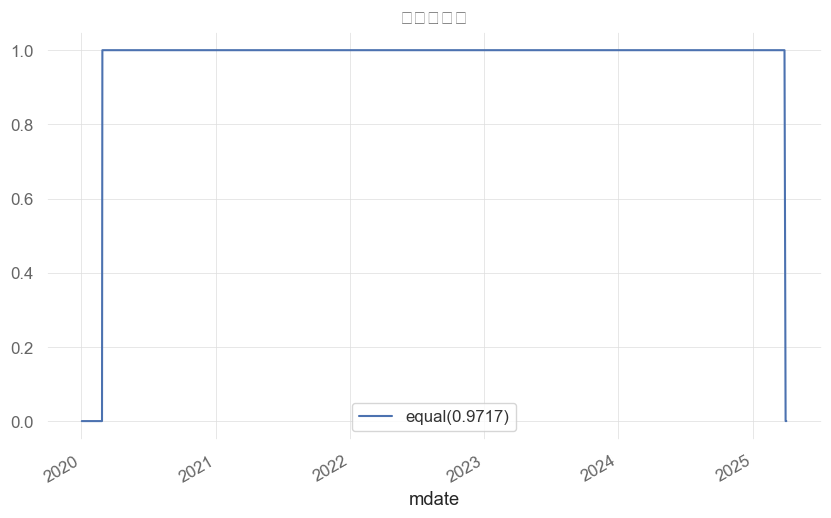

In [49]:
import warnings
warnings.filterwarnings("ignore")
def max_drawdown(prices):
    # 計算累計的最大值
    cumulative_max = prices.cummax()
    # 計算回撤 (Drawdown)
    drawdown = (prices - cumulative_max) / cumulative_max
    # 計算最大回撤 (MDD)
    mdd = drawdown.min()
    return mdd
display(pd.concat({"CAGR(%)":bt_ret.mean() * 252 * 100,
        'Sharpe' : bt_ret.mean() / bt_ret.std()*252**0.5,
        'Calmar':bt_ret.mean() * 252 / abs(bt_ret.max_drawdown()),
        'MDD(%)' : bt_ret.max_drawdown()*100,
        '單利MDD(%)' : max_drawdown(bt_ret.cumsum().add(1))*100,
        '樣本勝率(%)' : bt_ret.apply(lambda X:((X.dropna()>0).sum() / X.dropna().shape[0])*100),
        '周勝率(%)' : bt_ret.apply(lambda X:((X.dropna().add(1).resample('W').prod().sub(1)>0).sum() / X.dropna().add(1).resample('W').prod().sub(1).dropna().shape[0])*100),
        '月勝率(%)' : bt_ret.apply(lambda X:((X.dropna().add(1).resample('ME').prod().sub(1)>0).sum() / X.dropna().add(1).resample('ME').prod().sub(1).shape[0])*100),
        '年勝率(%)' : bt_ret.apply(lambda X:((X.dropna().add(1).resample('YE').prod().sub(1)>0).sum() / X.dropna().add(1).resample('YE').prod().sub(1).shape[0])*100),
        'avg_win/avg_loss' : bt_ret.apply(lambda X:(X[X > 0].mean() / abs(X[X < 0].mean()))),
        'profit_factor' : bt_ret.profit_factor(),
        },axis = 1).round(2))
bt_ret.cumsum().ffill().iplot()
bt_ret.to_drawdown_series().iplot(title = 'Drawdown')
pd.concat({
    f'equal({round(weightings["ic_ir"].loc["2020":].sum(axis=1).mean(), 4)})': weightings['ic_ir'].loc["2020":].sum(axis=1),
}, axis=1).plot(title='現金使用率')


In [55]:
actual_weight = weightings['ic_ir'].loc['2025-03-20']
actual_set = set(actual_weight[actual_weight > 0].dropna().index)

In [56]:
actual_set

{'1101',
 '1301',
 '1303',
 '1326',
 '1536',
 '2002',
 '2027',
 '2049',
 '2340',
 '2344',
 '2354',
 '2408',
 '2615',
 '3019',
 '3081',
 '3189',
 '3711',
 '5371',
 '6213',
 '6770'}